# ConvCNP for Interpolating Temperature from Sensor Readings and ERA5

The first small-scale experiment to use a ConvCNP to interpolate sensor temperature readings, with topography, ERA5, and sensor layers.

### Project setup and imports

In [1]:
# setup project root for imports (requirement for all notebooks in this repo)
import sys
from pathlib import Path

# Make project root importable
ROOT = Path().resolve().parents[1]
sys.path.append(str(ROOT))

In [2]:
# useful while developing - reloads modules automatically before executing code
%load_ext autoreload

In [ ]:
%autoreload 2
from src.utils.variables.var_names import *
from src.utils.variables.coord_names import *
from src.data_processing.conversions.scalar_conversions import *
from src.config.env_loader import get_env_var
import src.learning.model_diagnostics as model_diagnostics
from src.learning.model_training import batch_data_by_num_stations, compute_val_loss

from src.data_processing.station_processor import ProcessStations
from src.data_processing.topography_processor import ProcessTopography
from src.data_processing.era5_processor import ProcessERA5

from src.data_processing.auxiliary.sun_position import get_sun_culmination

In [4]:
# DeepSensor imports
# note this pulls from a fork of DeepSensor.
import deepsensor.torch
from deepsensor.train.train import train_epoch, set_gpu_default_device
from deepsensor.data.loader import TaskLoader
from deepsensor.data.processor import DataProcessor
from deepsensor.model.convnp import ConvNP
from deepsensor.data.utils import construct_x1x2_ds

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from mpl_toolkits.basemap import Basemap
import torch
from torch import optim
import os
import lab as B
from tqdm import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cf

### Project Variables

In [5]:
# setup variables for experiment
var = TEMPERATURE
years = [2010, 2011, 2012, 2013, 2014]

train_years = [2010] #[2010, 2011, 2012, 2013]
validation_years = [2014]

# GPU settings
use_gpu = True
if use_gpu:
    cuda_device = int(get_env_var("CUDA_DEVICE"))
    set_gpu_default_device(backend="cuda", dev_id=cuda_device)

# visualisations of data
DEBUG_PLOTS = True

### Load datasets

In [6]:
# dataset loader modules. These are from src.data_processing.
#    They use a file loader module in src.data_processing.file_loaders to load raw data files,
#    in the case of getting data in a different structure, changes will need to be made to the file loader modules.
station_processor = ProcessStations()
topography_processor = ProcessTopography()
era5_processor = ProcessERA5()

# topography and ERA5 datasets are loaded as simple xarray datasets
topography_ds = topography_processor.load_ds(standardise_var_names=True, standardise_coord_names=True)
era5_ds = era5_processor.load_ds(mode="surface", years=years, standardise_var_names=True, standardise_coord_names=True)

### Build Context Set 1

First, clean up the ERA5 data & add to it to build context set 1:

- convert from kelvin to celsius
- crop the dataset to a smaller area
- add in sun culmination data

In [7]:
# clean up the ERA5 data:
# get variable filters a dataset to a single variable dataarray
era5_var = era5_processor.get_variable(era5_ds, var) # set variable to process - e.g. "temperature"

if var == TEMPERATURE:
    era5_var = kelvin_to_celsius(era5_var)

era5_ds[var] = era5_var

In [8]:
# I decided not to crop the dataset, but kept this code here in case it's needed later.
"""
crop_left = 166
crop_right = 176
crop_top = -38
crop_bottom = -48

era5_ds = era5_ds.sel(lat=slice(crop_top, crop_bottom), lon=slice(crop_left, crop_right))
topography_ds = topography_ds.sel(lat=slice(crop_bottom, crop_top), lon=slice(crop_left, crop_right))

"""

'\ncrop_left = 166\ncrop_right = 176\ncrop_top = -38\ncrop_bottom = -48\n\nera5_ds = era5_ds.sel(lat=slice(crop_top, crop_bottom), lon=slice(crop_left, crop_right))\ntopography_ds = topography_ds.sel(lat=slice(crop_bottom, crop_top), lon=slice(crop_left, crop_right))\n\n'

In [9]:
# add on sun culmination as context
# encodes temporal non-stationarity related to annual solar cycle
era5_ds[SUN_CULMINATION] = get_sun_culmination(era5_ds.coords)

era5_ds = era5_ds[[var, SUN_CULMINATION]]

In [10]:
# coarsen ERA5
era5_ds_coarsen = era5_ds.coarsen(lat=2, lon=2, boundary='trim').mean()

Validate context set 1

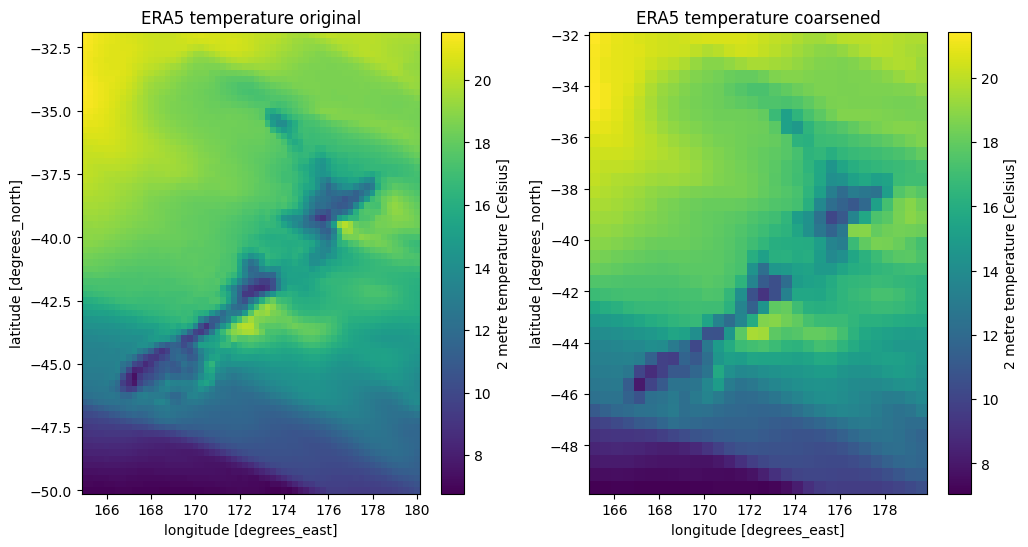

In [11]:
if DEBUG_PLOTS:
    # visual check of correctness
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    era5_ds.sel(time="2010-01-01T18:00")[var].plot(ax=ax[0])
    ax[0].set_title(f"ERA5 {var} original") 
    era5_ds_coarsen.sel(time="2010-01-01T18:00")[var].plot(ax=ax[1])
    ax[1].set_title(f"ERA5 {var} coarsened")
    plt.show()

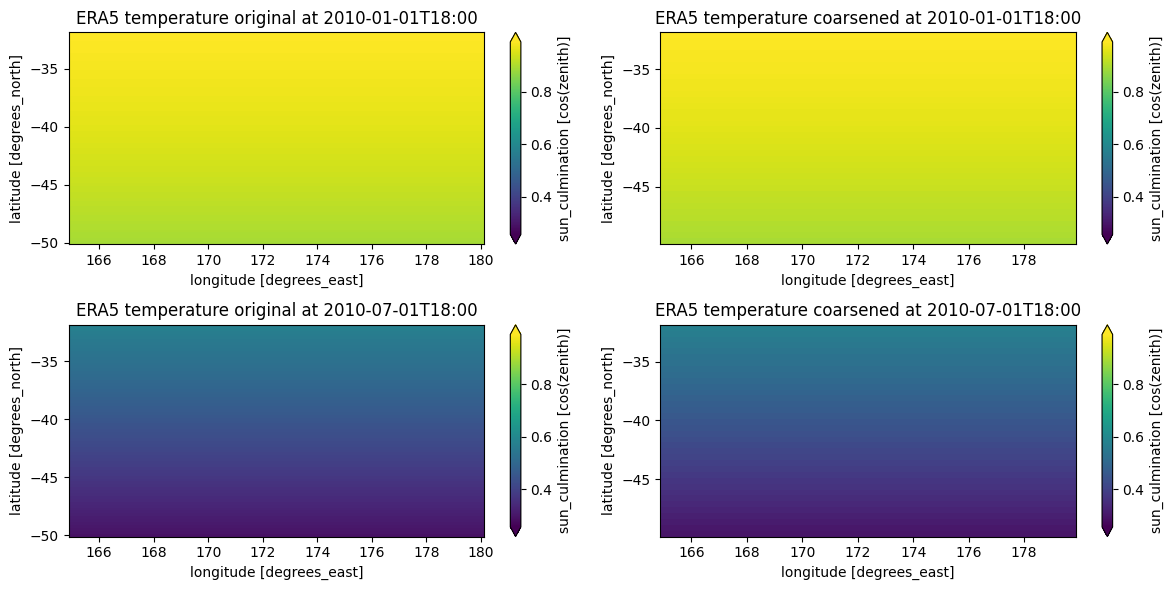

In [12]:
if DEBUG_PLOTS:
    fig, ax = plt.subplots(2, 2, figsize=(12, 6))
    vmin = era5_ds[SUN_CULMINATION].max()
    vmax = era5_ds[SUN_CULMINATION].min()

    era5_ds.sel(time="2010-01-01T18:00")[SUN_CULMINATION].plot(
        ax=ax[0, 0], vmin=vmin, vmax=vmax
    )
    ax[0, 0].set_title(f"ERA5 {var} original at 2010-01-01T18:00")

    era5_ds_coarsen.sel(time="2010-01-01T18:00")[SUN_CULMINATION].plot(
        ax=ax[0, 1], vmin=vmin, vmax=vmax
    )
    ax[0, 1].set_title(f"ERA5 {var} coarsened at 2010-01-01T18:00")

    era5_ds.sel(time="2010-07-01T18:00")[SUN_CULMINATION].plot(
        ax=ax[1, 0], vmin=vmin, vmax=vmax
    )
    ax[1, 0].set_title(f"ERA5 {var} original at 2010-07-01T18:00")

    era5_ds_coarsen.sel(time="2010-07-01T18:00")[SUN_CULMINATION].plot(
        ax=ax[1, 1], vmin=vmin, vmax=vmax
    )
    ax[1, 1].set_title(f"ERA5 {var} coarsened at 2010-07-01T18:00")

    plt.tight_layout()
    plt.show()

### Build the auxilliary set
- Get the topographic data from the topography processor
- Compute the topographic position index
- Coarsen
- Fill NA values with 0

In [13]:
# Compute the topographic position index (TPI) from elevation data
ds_aux = topography_processor.compute_tpi(topography_ds)

# coarsen the elevation data
ds_aux_coarse  = ds_aux.coarsen(lat=100, lon=100, boundary='trim').mean()

ds_aux = ds_aux.fillna(0)
ds_aux_coarse = ds_aux_coarse.fillna(0)

validate the auxilliary dataset

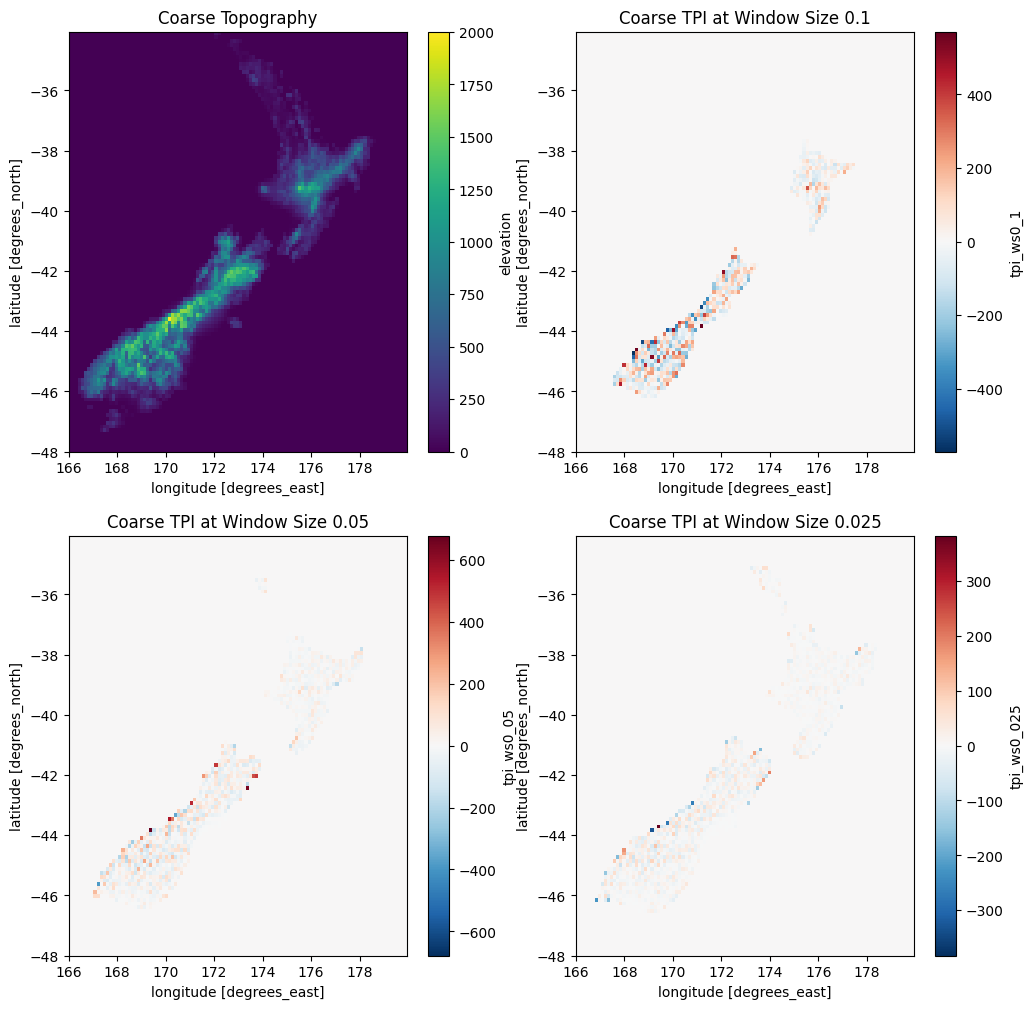

In [14]:
if DEBUG_PLOTS:
    fig, ax = plt.subplots(2, 2, figsize=(12, 12))
    
    ds_aux_coarse[ELEVATION].plot(ax=ax[0, 0])
    ax[0, 0].set_title("Coarse Topography")
    
    ds_aux_coarse[f"{TOPOGRAPHIC_POSITION_INDEX}_ws0_1"].plot(ax=ax[0, 1])
    ax[0, 1].set_title("Coarse TPI at Window Size 0.1")
    
    ds_aux_coarse[f"{TOPOGRAPHIC_POSITION_INDEX}_ws0_05"].plot(ax=ax[1, 0])
    ax[1, 0].set_title("Coarse TPI at Window Size 0.05")
    
    ds_aux_coarse[f"{TOPOGRAPHIC_POSITION_INDEX}_ws0_025"].plot(ax=ax[1, 1])
    ax[1, 1].set_title("Coarse TPI at Window Size 0.025")
    
    plt.show()

### Load the stations (Context set 2 & target set)
Not all stations load temperature across all timestamps.

Desired data format:

| lat | long | time | temperature |
|:---:|:----:|:----:|:-----------:|
| float | float | timestamp | float |
| float | float | timestamp | float |

In [15]:
# load the stations with the variable of interest between the start and end years
stations_df = station_processor.load_df(vars=[var], year_start=2010, year_end=2014)
stations_df.head()
stations_reset = stations_df.reset_index()
stations_reset.drop(columns=['station'], inplace=True)

# resample to six-hourly frequency to match ERA5 timestamps
stations_resample = stations_reset.groupby(['lat', 'lon']).resample("6h", on='time').mean()[['temperature']]
stations_resample = stations_resample.reset_index().set_index(['time', 'lat', 'lon']).sort_index()

"""
# this is excluded as we are not cropping the dataset

# slice to smaller area for proof-of-concept
stations_resample = stations_resample[(stations_resample.index.get_level_values('lat') > crop_bottom) & (stations_resample.index.get_level_values('lat') < crop_top) &
                                      (stations_resample.index.get_level_values('lon') > crop_left) & (stations_resample.index.get_level_values('lon') < crop_right)]
"""

/home/crowelenn/niwa/convcnp-assim-nz/src/data_processing/station_processor.py:157: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',) The recommendation is to set join explicitly for this case.
  ds_comb = xr.concat([first, *station_iter], dim="station")
/tmp/ipykernel_120714/1774430846.py:8: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stations_resample = stations_reset.groupby(['lat', 'lon']).resample("6h", on='time').mean()[['temperature']]


"\n# this is excluded as we are not cropping the dataset\n\n# slice to smaller area for proof-of-concept\nstations_resample = stations_resample[(stations_resample.index.get_level_values('lat') > crop_bottom) & (stations_resample.index.get_level_values('lat') < crop_top) &\n                                      (stations_resample.index.get_level_values('lon') > crop_left) & (stations_resample.index.get_level_values('lon') < crop_right)]\n"

validate the stations data

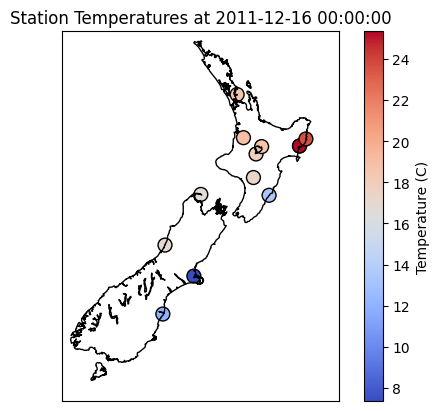

In [16]:
# plot temperature across all locations using temperature colormap at a single time step
# plot on a map of NZ using basemap
time_step = "2011-12-16 00:00:00"
m = Basemap(projection='merc', llcrnrlat=-48, urcrnrlat=-34, llcrnrlon=166, urcrnrlon=180, resolution='i')
m.drawcoastlines()
m.drawcountries()
x, y = m(stations_resample.reset_index().loc[stations_resample.reset_index()['time'] == time_step]['lon'].values,
           stations_resample.reset_index().loc[stations_resample.reset_index()['time'] == time_step]['lat'].values)
sc = m.scatter(x, y,
               c=stations_resample.reset_index().loc[stations_resample.reset_index()['time'] == time_step]['temperature'].values,
               cmap='coolwarm', marker='o', edgecolor='k', s=100)
plt.colorbar(sc, label='Temperature (C)')
plt.title(f'Station Temperatures at {time_step}')
plt.show()

### Normalisation and Preprocessing

In [17]:
data_processor = DataProcessor(x1_name=LATITUDE, x1_map=(era5_ds[LATITUDE].min(), era5_ds[LATITUDE].max()), x2_name=LONGITUDE, x2_map=(era5_ds[LONGITUDE].min(), era5_ds[LONGITUDE].max()))
era5_processed, station_processed = data_processor([era5_ds_coarsen, stations_resample])
ds_aux_processed, ds_aux_coarse_processed = data_processor([ds_aux, ds_aux_coarse], method='min_max')

# transfer learning will need something more clever than this, as the input data grid will be different at each step
x1x2_ds = construct_x1x2_ds(ds_aux_coarse_processed)
ds_aux_coarse_processed['x1_arr'] = x1x2_ds['x1_arr']
ds_aux_coarse_processed['x2_arr'] = x1x2_ds['x2_arr']

/home/crowelenn/niwa/convcnp-assim-nz/venv/src/deepsensor/deepsensor/data/processor.py:129: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f"x1_map={x1_map} and x2_map={x2_map} have different ranges ({float(np.diff(x1_map))} "
/home/crowelenn/niwa/convcnp-assim-nz/venv/src/deepsensor/deepsensor/data/processor.py:130: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f"and {float(np.diff(x2_map))}, respectively). "
/home/crowelenn/niwa/convcnp-assim-nz/venv/src/deepsensor/deepsensor/data/processor.py:128: UserWarning: x1_map=(-50.0, -32.0) and x2_map=(165.0, 180.0) have different ranges (18.0 and 15.0, respectively). This can lead to stretching

In [18]:
print(data_processor)

DataProcessor with normalisation params:
{'coords': {'time': {'name': 'time'},
            'x1': {'map': (-50.0, -32.0), 'name': 'lat'},
            'x2': {'map': (165.0, 180.0), 'name': 'lon'}},
 'elevation': {'method': 'min_max',
               'params': {'max': 3655.506591796875,
                          'min': -26.582759857177734}},
 'sun_culmination': {'method': 'mean_std',
                     'params': {'mean': 0.7219775629216937,
                                'std': 0.19539264150939725}},
 'temperature': {'method': 'mean_std',
                 'params': {'mean': 13.548419952392578,
                            'std': 4.273066997528076}},
 'tpi_ws0_025': {'method': 'min_max',
                 'params': {'max': 1339.210205078125,
                            'min': -789.6385498046875}},
 'tpi_ws0_05': {'method': 'min_max',
                'params': {'max': 1790.2523193359375,
                           'min': -940.9993286132812}},
 'tpi_ws0_1': {'method': 'min_max',
            

In [19]:
task_loader = TaskLoader(
        context = [station_processed, era5_processed, ds_aux_coarse_processed], 
        target = station_processed, 
        aux_at_targets = ds_aux_processed, 
        links = [(0, 0)])

In [20]:
model = ConvNP(data_processor, task_loader, unet_channels=(64,)*5, likelihood="gnp")

dim_yc inferred from TaskLoader: (1, 2, 6)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 4
Setting aux_t_mlp_layers: (64, 64, 64)
internal_density inferred from TaskLoader: 6877
encoder_scales inferred from TaskLoader: [7.270612185546023e-05, 0.01388888992369175, 0.0035555537324398756]
decoder_scale inferred from TaskLoader: 0.00014541224371092046


### Investigating why the default internal grid is so dense
The model internal grid has a density of 6877. This is very high, and causes large tensors to be created inside the model (~2 billion values). We need a better understanding of why this happens.

In [21]:
import pandas as pd

from deepsensor.data.utils import (
    compute_xarray_data_resolution,
    compute_pandas_data_resolution,
)

variables = {
    "station_processed": station_processed,
    "era5_processed": era5_processed,
    "ds_aux_coarse_processed": ds_aux_coarse_processed,
}

for name, var in variables.items():
    if isinstance(var, (xr.DataArray, xr.Dataset)):
        # Gridded variable: use data resolution
        data_resolution = compute_xarray_data_resolution(var)
    elif isinstance(var, (pd.DataFrame, pd.Series)):
        # Point-based variable: calculate density
        data_resolution = compute_pandas_data_resolution(
            var, n_times=1000, percentile=5
        )
    else:
        continue

    print(f"{name}: data resolution = {1/data_resolution}")

station_processed: data resolution = 6877.478607561156
era5_processed: data resolution = 36.0
ds_aux_coarse_processed: data resolution = 140.62507210568643


From deepsensor: `# Point-based variable: calculate density based on pairwise distances between observations`

`The resolution is approximated as the Nth percentile of the distances
    between neighbouring observations, possibly using a subset of the dates in
    the data. The default is to use 1000 dates (or all dates if there are fewer
    than 1000) and to use the 5th percentile. This means that the resolution is
    the distance between the closest 5% of neighbouring observations.`

In [22]:
# this is the function deepsensor use, but I modified it to also return the list of distances:
import scipy
def compute_pandas_data_resolution(
    df,
    n_times = 1000,
    percentile = 5,
):
    """Approximates the resolution of non-gridded pandas data with indexes time,
    x1, and x2.

    The resolution is approximated as the Nth percentile of the distances
    between neighbouring observations, possibly using a subset of the dates in
    the data. The default is to use 1000 dates (or all dates if there are fewer
    than 1000) and to use the 5th percentile. This means that the resolution is
    the distance between the closest 5% of neighbouring observations.

    Args:
        df (:class:`pandas.DataFrame` | :class:`pandas.Series`):
            Dataframe or series with indexes time, x1, and x2.
        n_times (int, optional):
            Number of dates to sample. Defaults to 1000. If "all", all dates
            are used.
        percentile (int, optional):
            Percentile of pairwise distances for computing the resolution.
            Defaults to 5.

    Returns:
        float: Resolution of the data (in spatial units, e.g. 0.1 degrees).
    """
    dates = df.index.get_level_values("time").unique()

    if n_times != "all" and len(dates) > n_times:
        rng = np.random.default_rng(42)
        dates = rng.choice(dates, size=n_times, replace=False)

    closest_distances = []
    df = df.reset_index().set_index("time")
    for time in dates:
        df_t = df.loc[[time]]
        X = df_t[["x1", "x2"]].values  # (N, 2) array of coordinates
        if X.shape[0] < 2:
            # Skip this time if there are fewer than 2 stationS
            continue
        X_unique = np.unique(X, axis=0)  # (N_unique, 2) array of unique coordinates

        pairwise_distances = scipy.spatial.distance.cdist(X_unique, X_unique)
        percentile_distances_without_self = np.ma.masked_equal(pairwise_distances, 0)

        # Compute the closest distance from each station to each other station
        closest_distances_t = np.min(percentile_distances_without_self, axis=1)
        closest_distances.extend(closest_distances_t)

    data_resolution = np.percentile(closest_distances, percentile)
    return data_resolution, closest_distances

In [23]:
res, dists = compute_pandas_data_resolution(station_processed)
# this is the station resolution
print(f"Station resolution: {res} => {1/res}")

Station resolution: 0.00014540212439201073 => 6877.478607561156


In [24]:
dists_sort = np.sort(dists)
set(dists_sort)

{np.float64(0.00014540212439201073),
 np.float64(0.02263853027664162),
 np.float64(0.02470115107029566),
 np.float64(0.026429859896024165),
 np.float64(0.05185481681686933),
 np.float64(0.05546184612644111),
 np.float64(0.06499568582074207),
 np.float64(0.11388813290242192),
 np.float64(0.11610188959133654),
 np.float64(0.16085396807276103)}

There are only 10 different distance values. The 5th percentile will always return 0.000145 as this appears enough times to be the fifth percentile. If 0.02263 was the resolution instead, the internal density would be only 1/0.0226 ~ 44. This would be much more reasonable. There are two stations which are too close together and it is making the internal_density way too large.

In [25]:
stations_unique = (
    stations_resample
    .reset_index()[["lat", "lon"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

coords = stations_unique[["lat", "lon"]].to_numpy()

dist_matrix = scipy.spatial.distance.cdist(coords, coords, metric="euclidean")  # distances in degrees

dist_matrix_km = dist_matrix * 111.0

pairs = []

n = len(stations_unique)
for i in range(n):
    for j in range(i + 1, n):
        pairs.append((i, j, dist_matrix_km[i, j]))

distances = pd.DataFrame(
    pairs,
    columns=["station_i", "station_j", "distance_km"]
).sort_values("distance_km").reset_index(drop=True)

distances["lat_i"] = distances["station_i"].map(stations_unique["lat"])
distances["lon_i"] = distances["station_i"].map(stations_unique["lon"])
distances["lat_j"] = distances["station_j"].map(stations_unique["lat"])
distances["lon_j"] = distances["station_j"].map(stations_unique["lon"])

distances.head(20)

,station_i,station_j,distance_km,lat_i,lon_i,lat_j,lon_j
0,9,10,0.283363,-38.66100,177.98600,-38.65860,177.98513
1,7,8,44.799918,-38.97352,175.79080,-38.68400,176.07200
2,13,14,45.186606,-37.00884,174.80713,-36.60268,174.83458
3,10,11,47.158797,-38.65860,177.98513,-38.38228,178.30785
4,9,11,47.259449,-38.66100,177.98600,-38.38228,178.30785
5,7,12,100.389445,-38.97352,175.79080,-38.33174,175.15356
6,6,7,103.143419,-39.89320,175.65799,-38.97352,175.79080
7,8,12,109.188074,-38.68400,176.07200,-38.33174,175.15356
8,4,6,116.072688,-40.57728,176.44889,-39.89320,175.65799
9,6,8,141.870373,-39.89320,175.65799,-38.68400,176.07200


Stations at (-38.66100, 177.98600) and (-38.65860, 177.98513) are only 280 metres apart. From a look at the station metadata, these are GISBORNE AERO and GISBORNE AERO AWS. For now, the model internal resolution can be set manually. In the future, options should be explored to either remove or combine close stations. For now, the internal resolution can be set to 140, as this is the internal_resolution if inferred from the coarsened topographic data.

In [26]:
model = ConvNP(data_processor, task_loader, unet_channels=(64,)*5, likelihood="gnp", internal_density=140)

dim_yc inferred from TaskLoader: (1, 2, 6)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 4
Setting aux_t_mlp_layers: (64, 64, 64)
encoder_scales inferred from TaskLoader: [0.0035714285714285713, 0.01388888992369175, 0.0035555537324398756]
decoder_scale inferred from TaskLoader: 0.007142857142857143


### Further visualisation & training loop

In [27]:
task_loader.load_dask()

In [28]:
train_dates = era5_ds.sel(time=slice("2010-01-01", "2011-12-31")).time.values
val_dates = era5_ds.sel(time=slice("2012-01-01", "2012-06-30")).time.values

In [29]:
from tqdm import tqdm
train_tasks = []
for date in tqdm(train_dates):
    #task = task_loader(date, context_sampling=["split"], target_sampling=["split"], split_frac=0.03)
    task = task_loader(date, context_sampling=["split", "all", "all"], target_sampling=["split"], split_frac=0.5)
    train_tasks.append(task)


val_tasks = []
for date in tqdm(val_dates):
    #task = task_loader(date, context_sampling="all", target_sampling="all")
    task = task_loader(date, context_sampling=["split", "all", "all"], target_sampling=["split"], split_frac=0.5)
    val_tasks.append(task)


100%|██████████| 728/728 [00:13<00:00, 53.11it/s]


plot the encodings of all context & aux sets

/home/crowelenn/niwa/convcnp-assim-nz/venv/lib/python3.12/site-packages/lab/types.py:204: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numerictypes.
  for name in np.core.numerictypes.__all__ + ["bool"]:


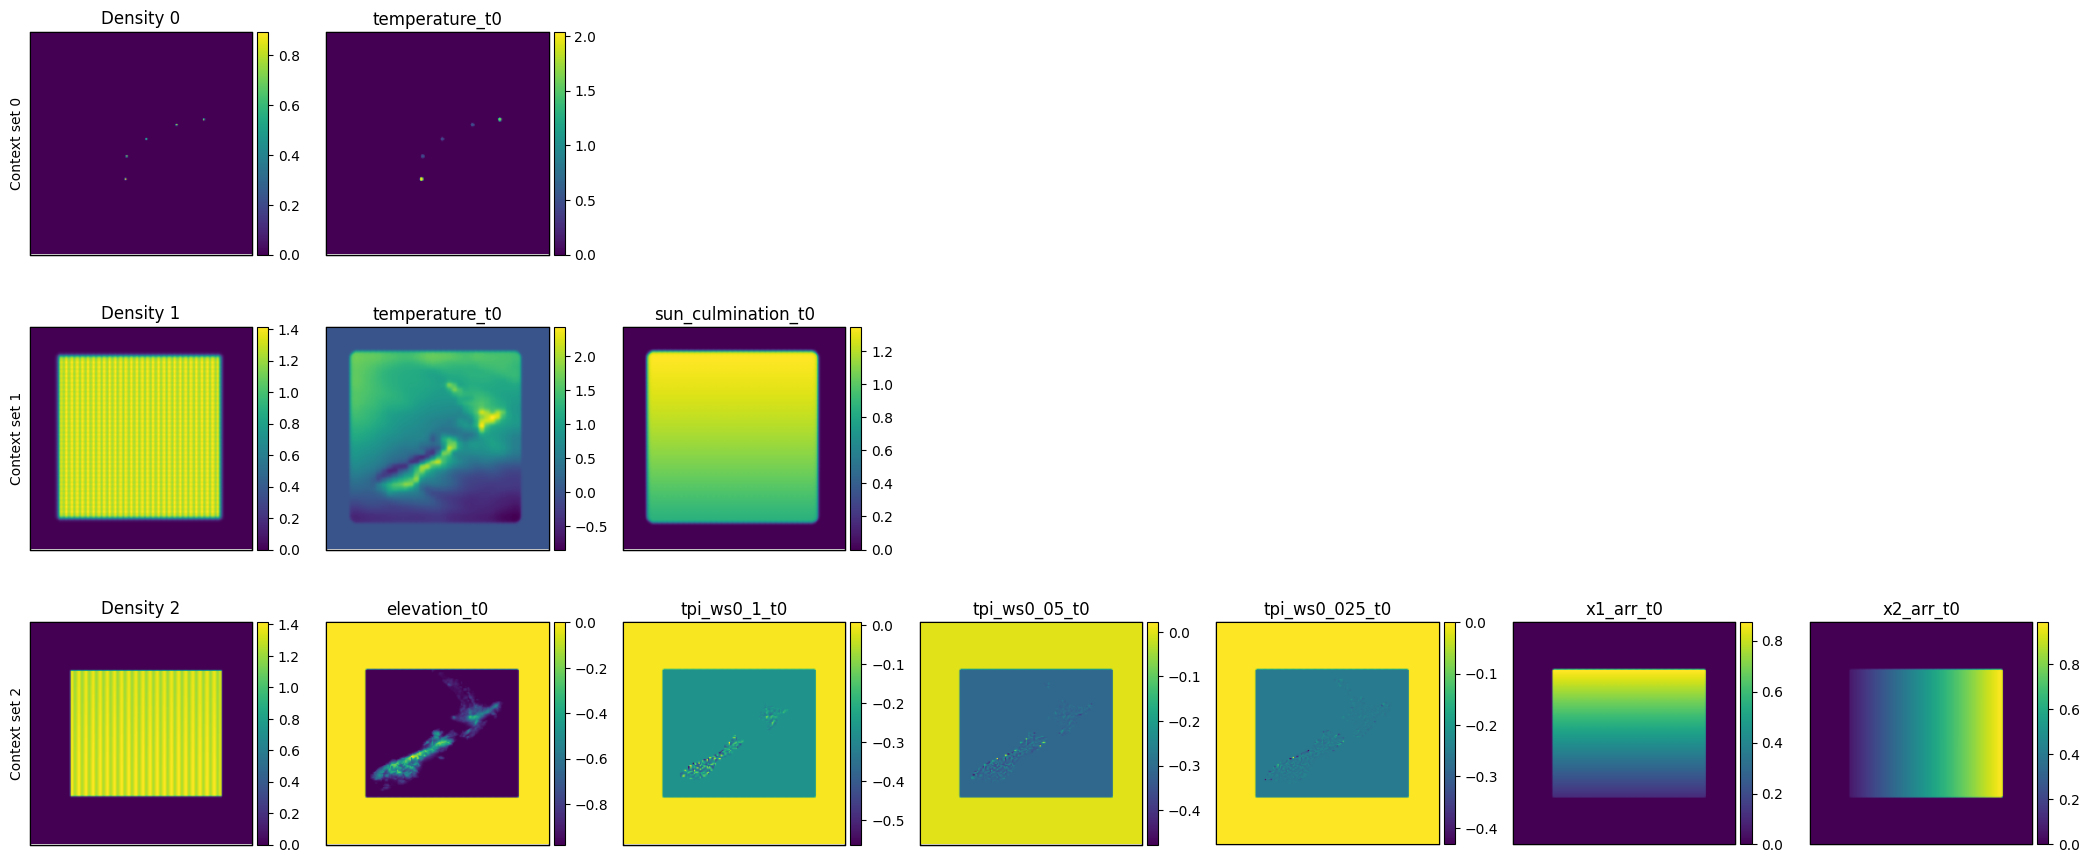

In [30]:
fig = deepsensor.plot.context_encoding(model, train_tasks[1], task_loader)

plot an entire task

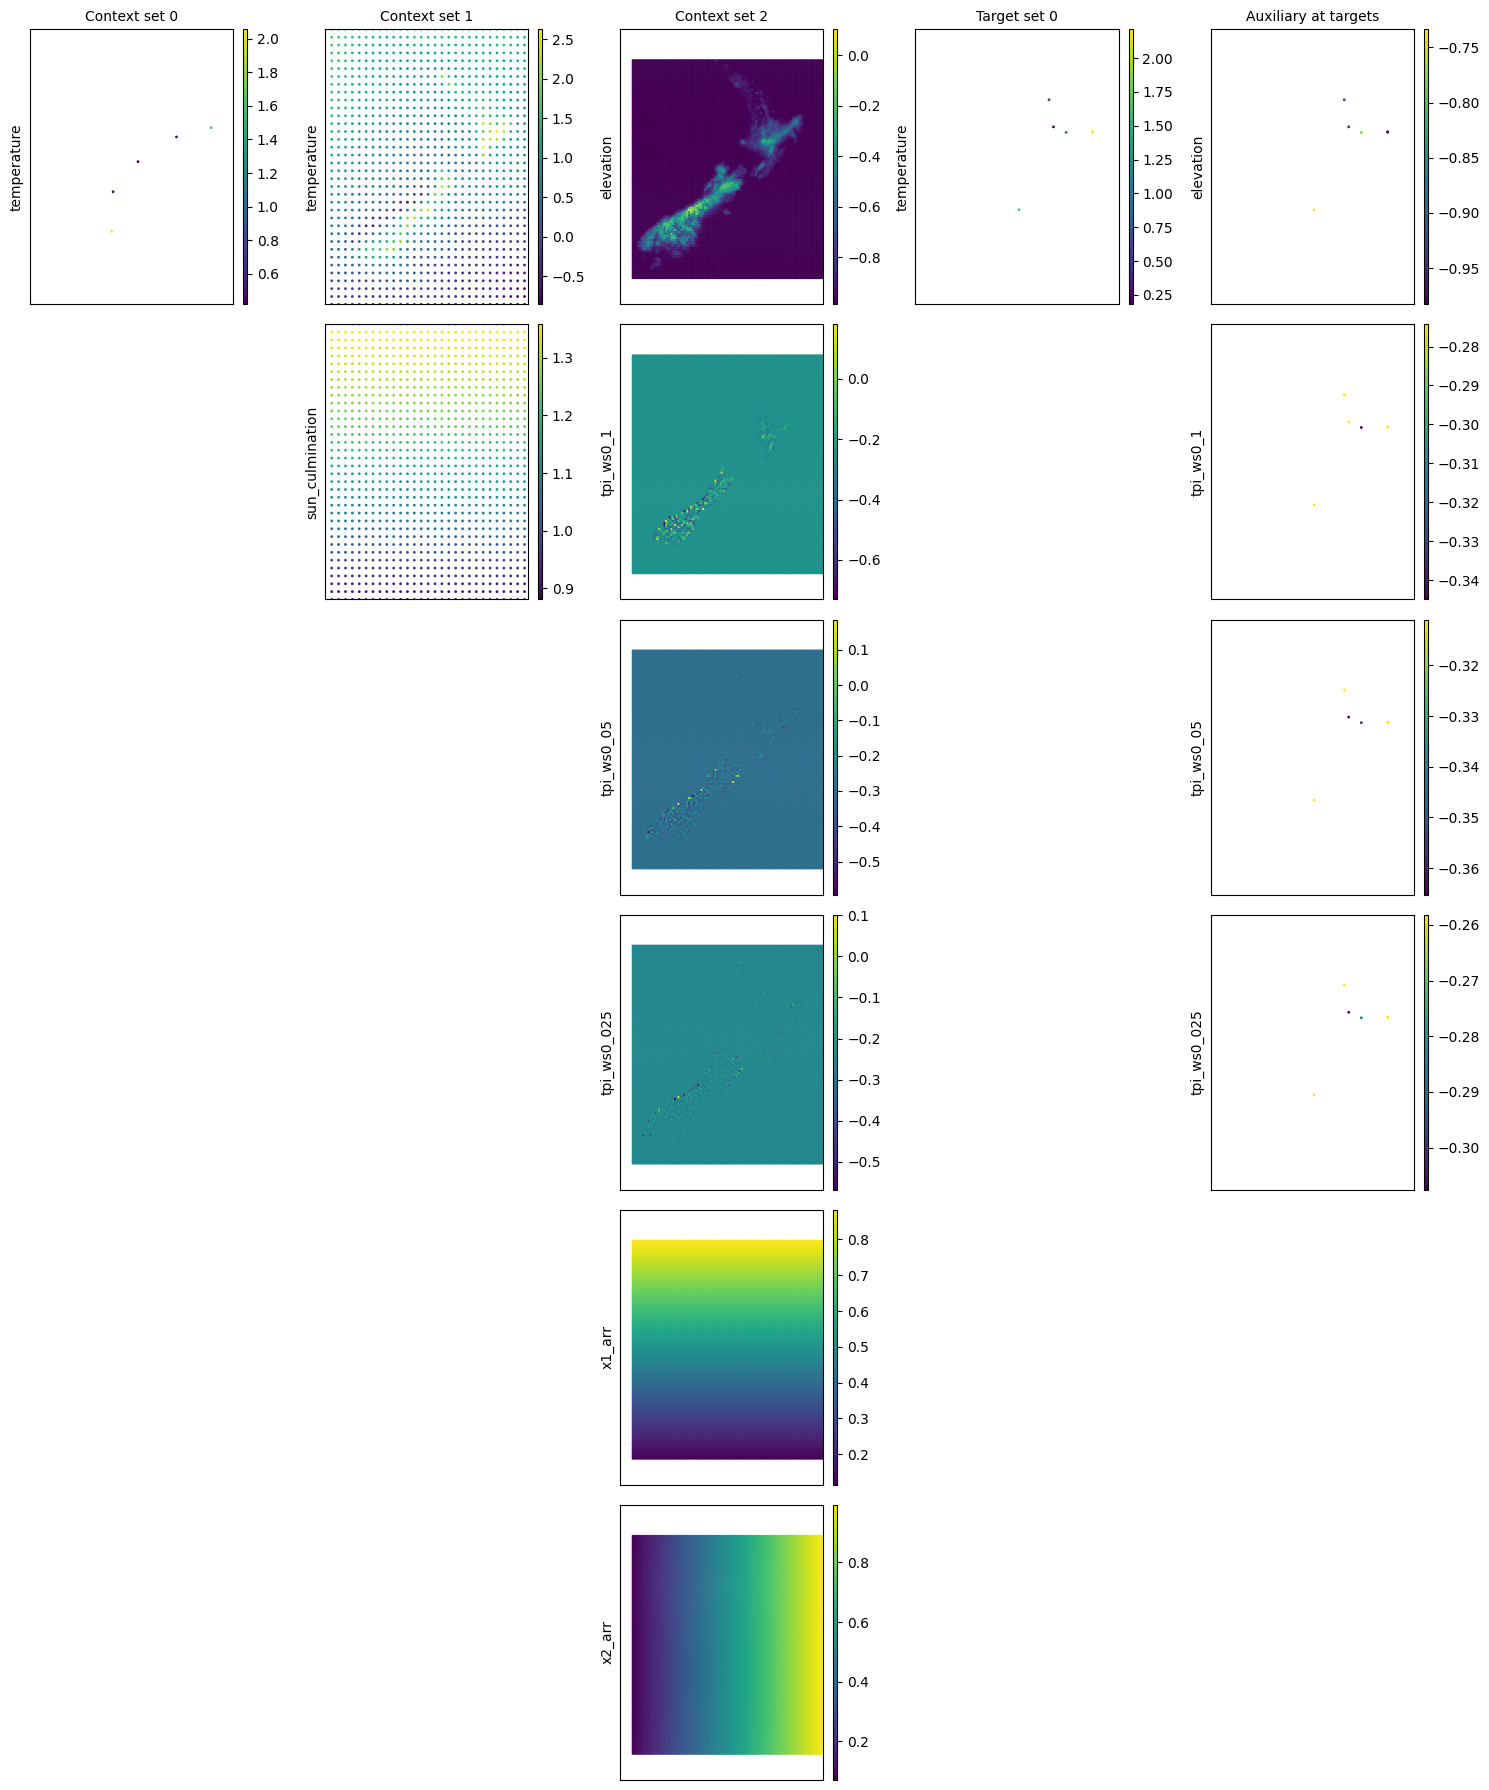

In [31]:
deepsensor.plot.task(train_tasks[1], task_loader)
plt.show()

Plot context & target stations (these are off-grid points)

/home/crowelenn/niwa/convcnp-assim-nz/venv/lib/python3.12/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/crowelenn/niwa/convcnp-assim-nz/venv/lib/python3.12/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


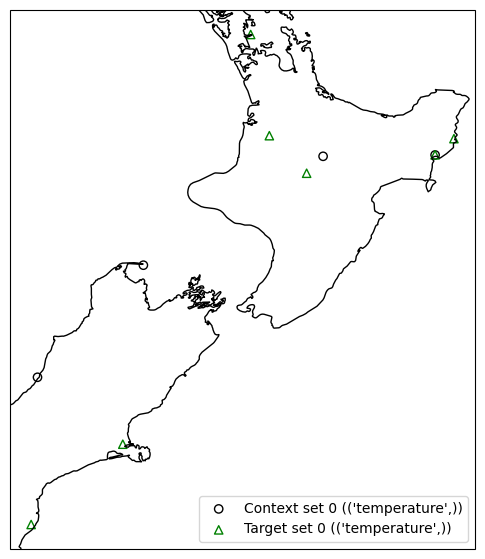

In [32]:
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': crs})
ax.coastlines()
ax.add_feature(cf.BORDERS)
deepsensor.plot.offgrid_context(ax, train_tasks[5], data_processor, task_loader, plot_target=True)
plt.show()

### Understanding the dimensionality of a Task

In [33]:
print(train_tasks[1])

time: 2010-01-01 06:00:00
ops: []
X_c: [(2, 5), ((1, 36), (1, 30)), ((1, 109), (1, 109))]
Y_c: [(1, 5), (2, 36, 30), (6, 109, 109)]
X_t: [(2, 6)]
Y_t: [(1, 6)]
Y_t_aux: (4, 6)



- three context sets
- X_c is the coordinates for the context sets
- Y_c is the values for the context sets
- 5, 36x30, 109x109 observations (Y_c)
- X_t is the target sensor coordinates
- Y_t is the target sensor values

### Understanding the ConvNP Architecture

In [34]:
assert str(type(model)) == "<class 'deepsensor.model.convnp.ConvNP'>"
assert str(type(model.model)) == "<class 'neuralprocesses.torch.Model'>"
assert str(type(model.model.encoder)) == "<class 'neuralprocesses.torch.FunctionalCoder'>"
assert str(type(model.model.decoder)) == "<class 'neuralprocesses.torch.Chain'>"

The ConvNP class has an encoder-decoder architecture, which encodes inputs onto the internal grid, with a latent representation. The full source for a ConvGNP can be found here: https://github.com/wesselb/neuralprocesses/blob/main/neuralprocesses/architectures/convgnp.py

## Encoder:
At a high level, the encoder is of class 'neuralprocesses.torch.FunctionalCoder'. This has a `.coder` field, which contains the Chain object.

Context Encoding:
- The SetConv encoder maps the context sets (ERA5, sensors, topology) to the ConvNP's internal grid.
- Place a Gaussian kernel at each (x, y) location (in space). Weight these by the observation values (e.g. temperature).
- Place a Gaussian kernel at each (x, y) location (in space). Weight by presence of input to create a density map.

A suitible input stucture could be:
- Context set 0: Sensor obs (with their own density channel). Density will be sparse.
- Context set 1: Complete sets of weather observations (ERA5, satellite etc). Density will be full.
- Context set 2: Stationary context data (sun incedence, topography etc). Density will be full.

One density channel per context set is created.

In [35]:
for i in range(len(model.model.encoder.coder.links)):
    print(f"Link {i}: {type(model.model.encoder.coder.links[i])}")
    print(model.model.encoder.coder.links[i])
    print("--------------------")

Link 0: <class 'neuralprocesses.torch.AssertParallel'>
AssertParallel()
--------------------
Link 1: <class 'neuralprocesses.torch.PrependDensityChannel'>
PrependDensityChannel()
--------------------
Link 2: <class 'neuralprocesses.torch.Parallel'>
Parallel(
    SetConv(),
    SetConv(),
    SetConv(),
)
--------------------
Link 3: <class 'neuralprocesses.torch.DivideByFirstChannel'>
DivideByFirstChannel()
--------------------
Link 4: <class 'neuralprocesses.torch.Concatenate'>
Concatenate()
--------------------
Link 5: <class 'neuralprocesses.torch.nn._LambdaModule'>
_LambdaModule()
--------------------
Link 6: <class 'neuralprocesses.torch.DeterministicLikelihood'>
DeterministicLikelihood()
--------------------


## Decoder

In [36]:
for i in range(len(model.model.decoder.links)):
    print(f"Link {i}: {type(model.model.decoder.links[i])}")
    print(model.model.decoder.links[i])
    print("--------------------")

Link 0: <class 'neuralprocesses.torch.UNet'>
UNet(
  (before_turn_layers): ModuleList(
    (0): Conv2d(12, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1-4): 4 x Sequential(
      (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
  )
  (after_turn_layers): ModuleList(
    (0): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1-3): 3 x Sequential(
      (0): Upsample(scale_factor=2.0, mode='bilinear')
      (1): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (4): Sequential(
      (0): Upsample(scale_factor=2.0, mode='bilinear')
      (1): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
  (final_linear): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
)
--------------------
Link 1: <class 'neuralprocesses.torch.RepeatForAggregateInputs'>
RepeatForAggregateInputs(
  (coder): Chain(
      SetConv(),
      _Lam

In [37]:
print(f"{model_diagnostics.count_model_parameters(model.model):,}")

Total number of parameters: 1372230
1,372,230


In [38]:
#find_model_structure(model.model)
model_diagnostics.model_parameters_by_layer(model.model)

Layer 0 (<class 'neuralprocesses.torch.FunctionalCoder'>):
    Layer 0 (<class 'neuralprocesses.torch.Discretisation'>):
        Layer (<class 'neuralprocesses.torch.Discretisation'>): 0 parameters
    Layer 1 (<class 'neuralprocesses.torch.Chain'>):
        Layer 0 (<class 'torch.nn.modules.container.ModuleList'>):
            Layer 0 (<class 'neuralprocesses.torch.AssertParallel'>):
                Layer (<class 'neuralprocesses.torch.AssertParallel'>): 0 parameters
            Layer 1 (<class 'neuralprocesses.torch.PrependDensityChannel'>):
                Layer (<class 'neuralprocesses.torch.PrependDensityChannel'>): 0 parameters
            Layer 2 (<class 'neuralprocesses.torch.Parallel'>):
                Layer 0 (<class 'torch.nn.modules.container.ModuleList'>):
                    Layer 0 (<class 'neuralprocesses.torch.SetConv'>):
                        Layer (<class 'neuralprocesses.torch.SetConv'>): 1 parameters
                    Layer 1 (<class 'neuralprocesses.torch.Set

In [39]:
model_diagnostics.model_dimensions_by_layer(model.model)

Layer 0 (<class 'neuralprocesses.torch.FunctionalCoder'>):
    Layer 0 (<class 'neuralprocesses.torch.Discretisation'>):
        Layer (<class 'neuralprocesses.torch.Discretisation'>):
    Layer 1 (<class 'neuralprocesses.torch.Chain'>):
        Layer 0 (<class 'torch.nn.modules.container.ModuleList'>):
            Layer 0 (<class 'neuralprocesses.torch.AssertParallel'>):
                Layer (<class 'neuralprocesses.torch.AssertParallel'>):
            Layer 1 (<class 'neuralprocesses.torch.PrependDensityChannel'>):
                Layer (<class 'neuralprocesses.torch.PrependDensityChannel'>):
            Layer 2 (<class 'neuralprocesses.torch.Parallel'>):
                Layer 0 (<class 'torch.nn.modules.container.ModuleList'>):
                    Layer 0 (<class 'neuralprocesses.torch.SetConv'>):
                        Layer (<class 'neuralprocesses.torch.SetConv'>):
                            Parameter: log_scale, Shape: torch.Size([])
                    Layer 1 (<class 'neura

In [40]:
model.config

{'dim_x': 2,
 'dim_yc': (1, 2, 6),
 'dim_yt': 1,
 'dim_aux_t': 4,
 'dim_lv': 0,
 'conv_arch': 'unet',
 'unet_channels': (64, 64, 64, 64, 64),
 'unet_resize_convs': True,
 'unet_resize_conv_interp_method': 'bilinear',
 'aux_t_mlp_layers': (64, 64, 64),
 'likelihood': 'lowrank',
 'unet_kernels': 5,
 'internal_density': 140,
 'encoder_scales': [0.0035714285714285713,
  0.01388888992369175,
  0.0035555537324398756],
 'encoder_scales_learnable': False,
 'decoder_scale': 0.007142857142857143,
 'decoder_scale_learnable': False,
 'num_basis_functions': 64,
 'epsilon': 0.01}

### Setting up for Model Training

In [42]:
task_batched = batch_data_by_num_stations(train_tasks, batch_size=16)

In [43]:
n_epochs = 3
train_losses = []
val_losses = []
lr=5e-5

output_model = False

val_loss_best = np.inf

opt = optim.Adam(model.model.parameters(), lr=lr)

for epoch in tqdm(range(n_epochs)):
    batch_losses = [train_epoch(model, task_batched[f'{num_stations}'], 
                                            batch_size=len(task_batched[f'{num_stations}']), 
                                            lr=lr, opt=opt) for num_stations in task_batched.keys()]
    
    train_loss = np.mean(batch_losses)
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss = compute_val_loss(model, val_tasks)
    val_losses.append(val_loss)

    if val_loss < val_loss_best:
        val_loss_best = val_loss
        if output_model:
            folder = os.path.join(get_env_var("OUTPUT_HOME"), "models", "downscaling", "temperature", "convcnp")
            if not os.path.exists(folder): os.makedirs(folder)
            torch.save(model.model.state_dict(), folder + f"model.pt")

    torch.cuda.empty_cache()

    print(f"Epoch {epoch} train_loss: {train_loss:.2f}, val_loss: {val_loss:.2f}")

 33%|███▎      | 1/3 [01:00<02:00, 60.48s/it]

Epoch 0 train_loss: 1.72, val_loss: 1.54


 67%|██████▋   | 2/3 [01:57<00:58, 58.25s/it]

Epoch 1 train_loss: 1.63, val_loss: 1.84


100%|██████████| 3/3 [02:53<00:00, 57.94s/it]

Epoch 2 train_loss: 1.59, val_loss: 1.89


Text(0, 0.5, 'Loss')

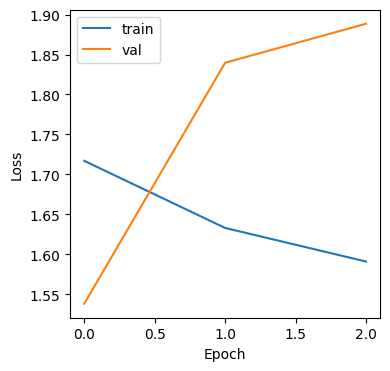

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(train_losses, label="train")
ax.plot(val_losses, label="val")
ax.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

The model can train itself - but we are currently not providing useful inputs, and it is therefore overfitting/not really learning.